# Modularized Steane Code

This notebook demonstrates a more modularized version of the Steane code which allows for encoding, unflagged syndrome measurement, decoding, and correction with minimal hardcoding.

Important Note #1: The encoding circuit is currently hardcoded, but it can (and should) also be generalized using the stabilizer tableau.

Important Note #2: This notebook relies on the qubits being ordered such that the index of each qubit is exactly the same as the bitstring which would result from an unflagged syndrome measurement to indicate that an error occurred on that qubit. This is crucial for ease of modularization, but it means that many other notebooks in this repository which were written prior to this modularization work use a different qubit ordering.

In [1]:
syndromes = []

# Adds the encoding circuit to create the logical basis states
def create_encodingcircuit(circuit):
    circuit.h(0)
    circuit.h(1)
    circuit.h(3)
    circuit.cx(0, 2)
    circuit.cx(1, 5)
    circuit.cx(3, 4)
    circuit.cx(3, 5)
    circuit.cx(1, 6)
    circuit.cx(0, 4)
    circuit.cx(1, 2)
    circuit.cx(4, 6)
    circuit.barrier()

#Adds a specified stabilizer on the circuit
def add_stabilizer(circuit, stabilizer_type, physical_indices, ancilla_index):
    if stabilizer_type == 'X':
        circuit.h(circuit.ancillas[ancilla_index])
        for index in physical_indices:
            circuit.cx(circuit.ancillas[ancilla_index], circuit.qregs[0][index])
        circuit.h(circuit.ancillas[ancilla_index])
        
    if stabilizer_type == 'Z':
        for index in physical_indices:
            circuit.cx(circuit.qregs[0][index], circuit.ancillas[ancilla_index])
    circuit.barrier()
    
def apply_recovery_gates(circuit, stabilizer_type):
    
    # Measurement
    for n in range(circuit.num_ancillas):
        circuit.measure(circuit.ancillas[n], n)
    circuit.barrier()

    # Applies recovery gates based on syndrome
    for n in range(1, pow(2, circuit.num_ancillas)):
        syndrome = bin(n)[2:]
        with circuit.if_test((circuit.cregs[0], int(syndrome))) as else_:
            syndromes.append(int(syndrome))
            if stabilizer_type == 'Z':
                circuit.x(n-1)
            if stabilizer_type == 'X':
                circuit.z(n-1)
    
    # Resets ancilla qubits to 0
    for n in range(circuit.num_ancillas):
        with circuit.if_test((circuit.cregs[0][n], 1)) as else_:
            circuit.x(circuit.ancillas[n])
            
    circuit.barrier()

In [2]:
from qiskit import QuantumRegister, ClassicalRegister, AncillaRegister, QuantumCircuit

l_qreg = QuantumRegister(7, 'q')
a_qreg = AncillaRegister(3, 'a')
creg = ClassicalRegister(3, 'c')
QEC_circuit = QuantumCircuit(l_qreg, a_qreg, creg)

create_encodingcircuit(QEC_circuit)

# Error occurs
QEC_circuit.z(5)
QEC_circuit.barrier()

# Decoding Phase
add_stabilizer(QEC_circuit, 'Z', [0,2,4,6], 0)
add_stabilizer(QEC_circuit, 'Z', [1,2,5,6], 1)
add_stabilizer(QEC_circuit, 'Z', [3,4,5,6], 2)
apply_recovery_gates(QEC_circuit, 'Z')
add_stabilizer(QEC_circuit, 'X', [0,2,4,6], 0)
add_stabilizer(QEC_circuit, 'X', [1,2,5,6], 1)
add_stabilizer(QEC_circuit, 'X', [3,4,5,6], 2)
apply_recovery_gates(QEC_circuit, 'X')

110


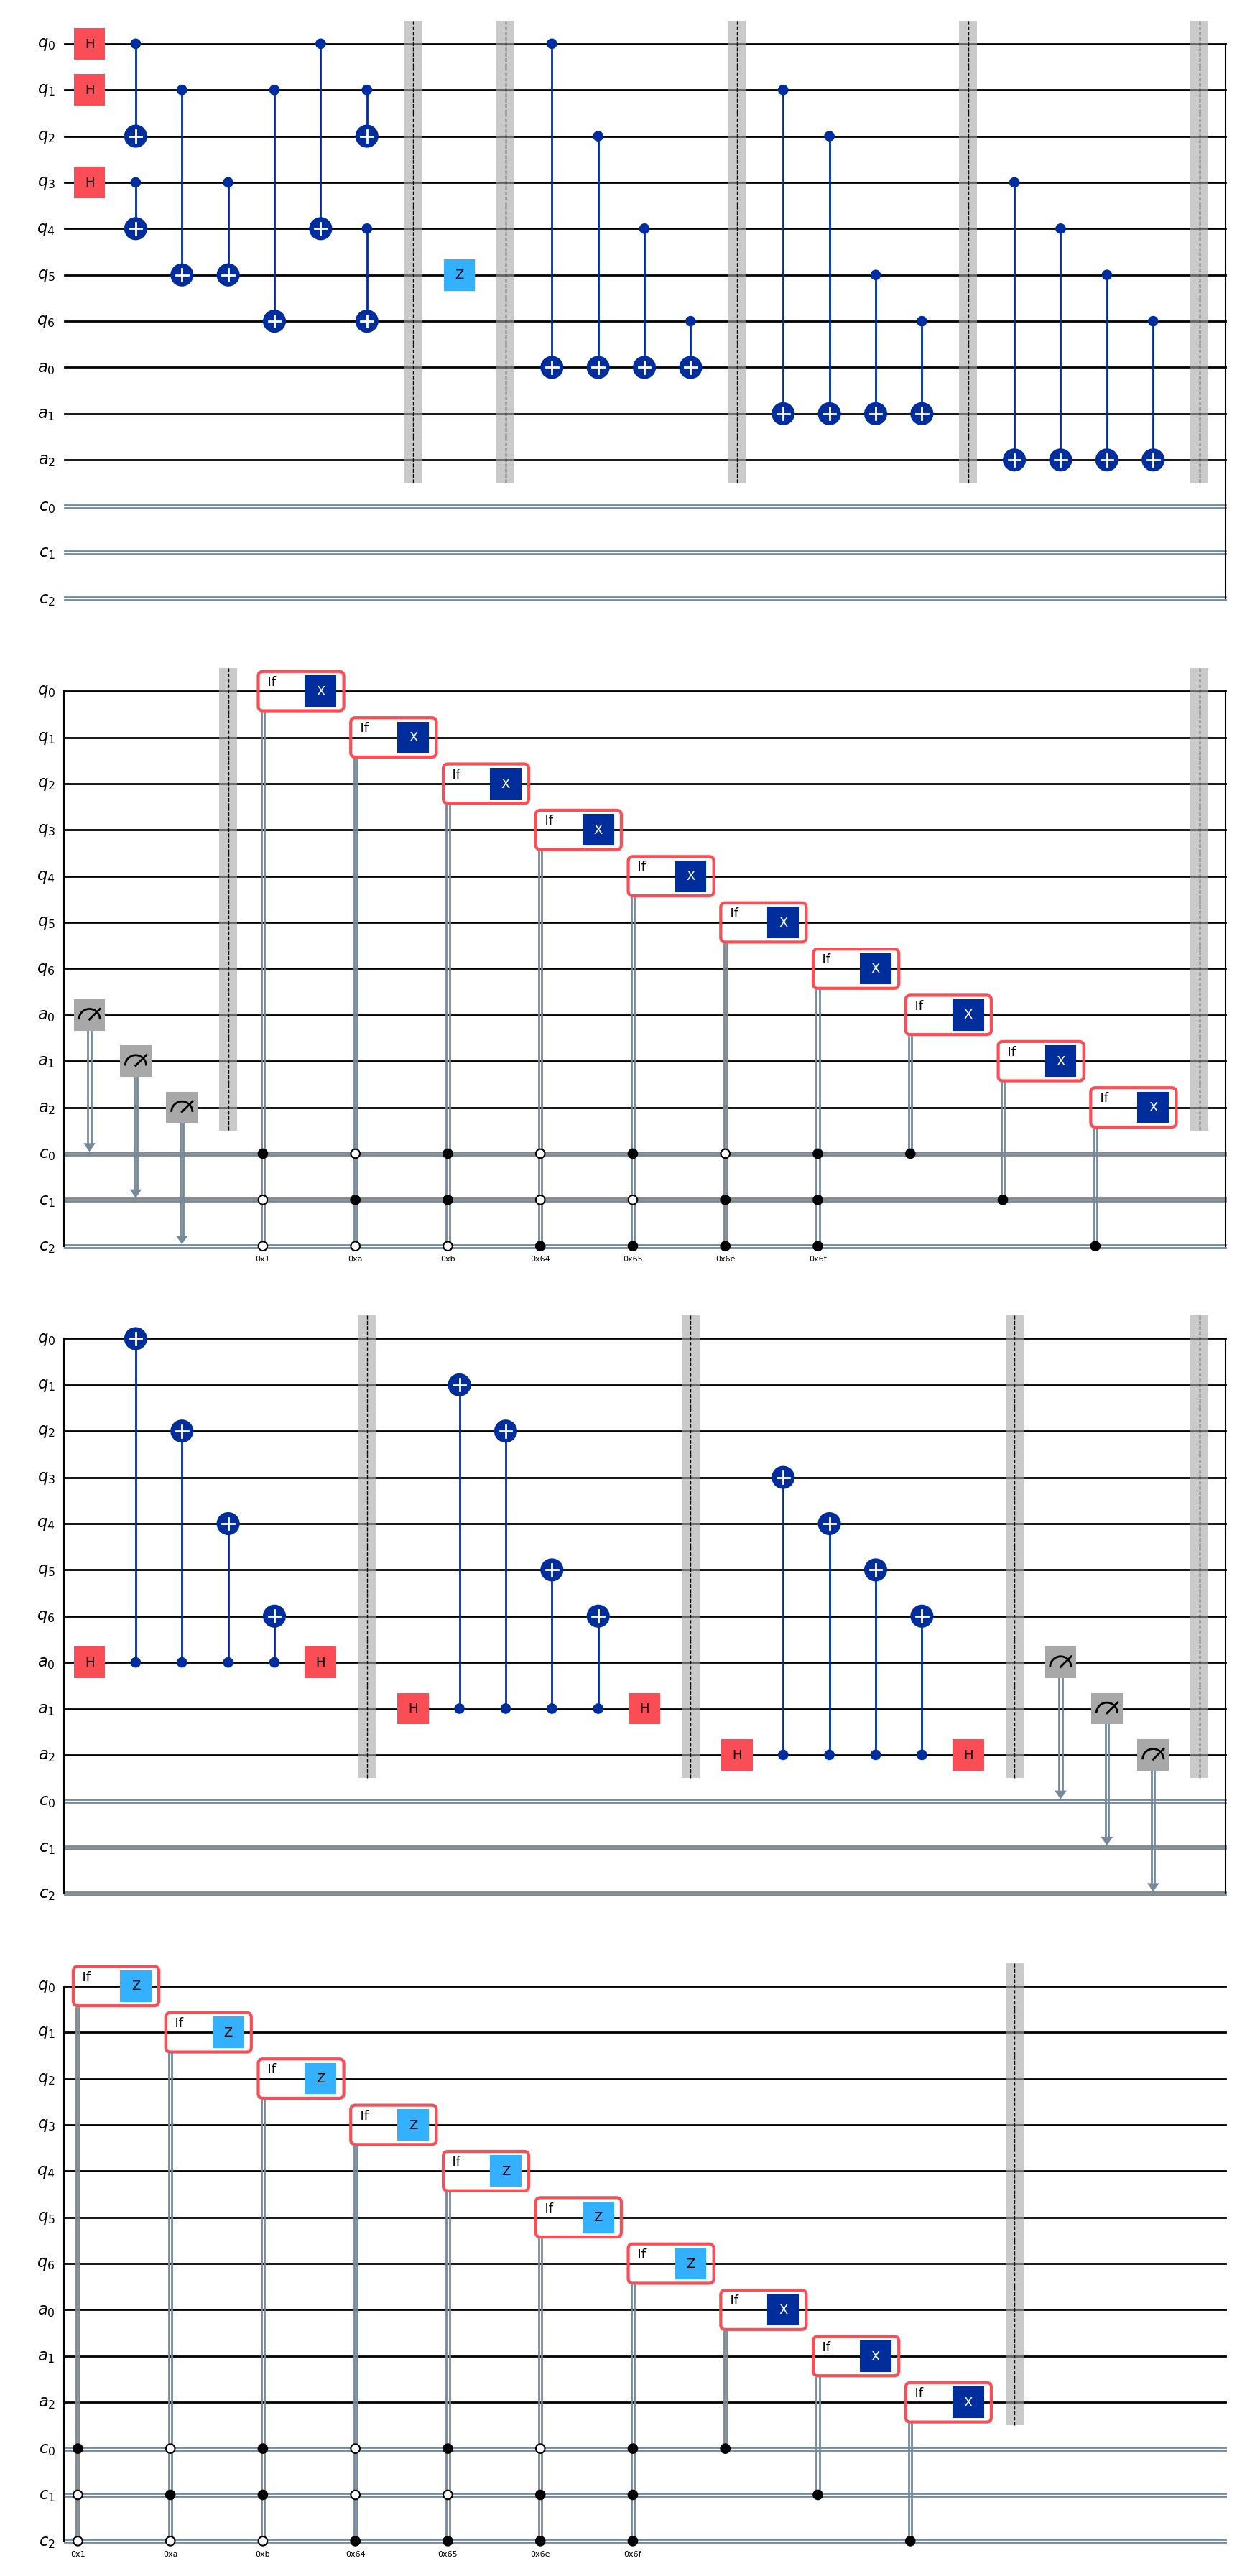

In [3]:
from qiskit_aer import AerSimulator
from qiskit import transpile

# Runs the circuit on the simulator and prints out the syndrome measurement
simulator = AerSimulator()
qc = transpile(QEC_circuit, backend=simulator)
result = simulator.run(qc, shots=1, memory=True).result()
X_syndrome = result.get_memory(QEC_circuit)[0]
print(X_syndrome)

# Draws final circuit with recovery gates
QEC_circuit.draw('mpl', style='iqp', cregbundle=False)